In [ ]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load dataset
def load_data(file_path):
    data = pd.read_csv(file_path)
    images = []
    labels = []
    for i in range(len(data)):
        try:
            pixel_values = list(map(int, data.iloc[i, 1].split(' ')))
            image = np.array(pixel_values).reshape(48, 48).astype('float32') / 255.0
            image = np.expand_dims(image, axis=-1)  # Add channel dimension
            label = data.iloc[i, 0]
            images.append(image)
            labels.append(label)
        except Exception as e:
            print(f"Error processing row {i}: {e}")
    return np.array(images), np.array(labels)

# Load and preprocess data
X, y = load_data('emotion.csv')
y = to_categorical(y, 7)  # 7 emotion classes

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=48)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

# Define MCNN model with dropout
def create_mcnn_model(input_shape):
    input = Input(shape=input_shape)

    # Column 1
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)
    x1 = Dropout(0.5)(x1)  # Add dropout

    # Column 2
    x2 = Conv2D(32, (5, 5), activation='relu', padding='same')(input)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (5, 5), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)
    x2 = Dropout(0.5)(x2)  # Add dropout

    # Column 3
    x3 = Conv2D(32, (7, 7), activation='relu', padding='same')(input)
    x3 = MaxPooling2D((2, 2))(x3)
    x3 = Conv2D(64, (7, 7), activation='relu', padding='same')(x3)
    x3 = MaxPooling2D((2, 2))(x3)
    x3 = Flatten()(x3)
    x3 = Dropout(0.5)(x3)  # Add dropout

    # Concatenate columns
    x = concatenate([x1, x2, x3])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout
    output = Dense(7, activation='softmax')(x)  # 7 emotion classes

    model = Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = create_mcnn_model((48, 48, 1))
model.summary()

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the training data
datagen.fit(X_train)

early_stopping = EarlyStopping(
    monitor='accuracy',  # Monitor the training accuracy
    patience=0,          # Number of epochs with no improvement after which training will be stopped
    mode='max',          # Stop when the monitored quantity has stopped increasing
    verbose=1,           # Verbosity mode, 1 = progress bar
    baseline=0.74        # Baseline value for the monitored quantity to reach. Training will stop when the accuracy is >= 0.74
)


# Train the model using data augmentation and class weights
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),epochs=250,validation_data=(X_test, y_test),class_weight=class_weights)

# Save the model
model.save('mcnn_emotion_recognition_model_v2.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
target_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print(report)


Error processing row 124: cannot reshape array of size 3541 into shape (48,48)
Error processing row 248: cannot reshape array of size 1602 into shape (48,48)
Error processing row 372: cannot reshape array of size 3390 into shape (48,48)
Error processing row 497: cannot reshape array of size 987 into shape (48,48)
Error processing row 623: cannot reshape array of size 2110 into shape (48,48)
Error processing row 747: invalid literal for int() with base 10: ''
Error processing row 872: cannot reshape array of size 219 into shape (48,48)
Error processing row 997: cannot reshape array of size 3201 into shape (48,48)
Error processing row 1121: cannot reshape array of size 2034 into shape (48,48)
Error processing row 1246: cannot reshape array of size 3498 into shape (48,48)
Error processing row 1370: cannot reshape array of size 1503 into shape (48,48)
Error processing row 1496: cannot reshape array of size 1649 into shape (48,48)
Error processing row 1620: cannot reshape array of size 3850

1/1 [==============================] - 0s 103ms/step
Predicted emotion: Angry
Recommended activity: Visualization exercises


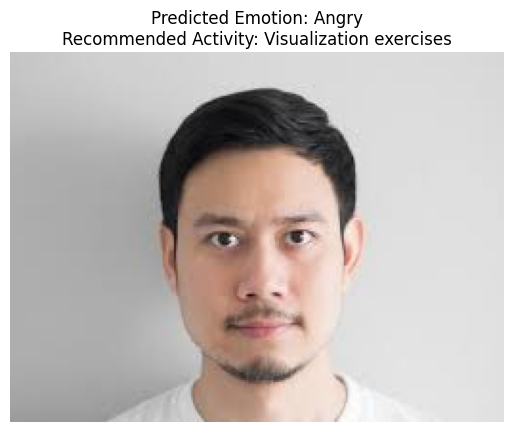

In [ ]:
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/content/mcnn_emotion_recognition_model_v2.h5')

def preprocess_input_image(image_path):
    """
    Load and preprocess the image for model prediction.
    """
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found or unable to load.")

    # Resize to match the model input size
    image = cv2.resize(image, (48, 48))

    # Normalize pixel values to [0, 1]
    image = image.astype('float32') / 255.0

    # Add channel and batch dimensions
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.expand_dims(image, axis=0)   # Add batch dimension

    return image

def predict_emotion(image_path):
    """
    Predict the emotion of the given image.
    """
    # Preprocess the image
    image = preprocess_input_image(image_path)

    # Make prediction
    prediction = model.predict(image)

    # Map the prediction to emotion class
    emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_class = emotion_classes[np.argmax(prediction)]

    return predicted_class

def load_activity_recommendations(csv_path):
    """
    Load activity recommendations from a CSV file.
    """
    df = pd.read_csv(csv_path)
    recommendations = {row['Emotion']: row['Activity'] for _, row in df.iterrows()}
    return recommendations

def recommend_activity(emotion, recommendations):
    """
    Recommend an activity based on the detected emotion.
    """
    return recommendations.get(emotion, "No recommendation available")

def display_image_with_recommendation(image_path, emotion, activity):
    """
    Display the image with the predicted emotion and recommended activity.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to load.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    plt.imshow(image)
    plt.title(f'Predicted Emotion: {emotion}\nRecommended Activity: {activity}')
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
image_path = '/content/normal.jpeg'  # Replace with your image path
csv_path = '/content/emotion_activities.csv'  # Replace with your CSV file path

# Load activity recommendations
recommendations = load_activity_recommendations(csv_path)

# Predict emotion
try:
    emotion = predict_emotion(image_path)
    print(f'Predicted emotion: {emotion}')

    # Recommend activity
    activity = recommend_activity(emotion, recommendations)
    print(f'Recommended activity: {activity}')

    # Display the image with prediction and recommendation
    display_image_with_recommendation(image_path, emotion, activity)
except Exception as e:
    print(f"Error: {e}")
